# Built-in Dynamical Models

@[Tianqiu Zhang](mailto:tianqiuakita@gmail.com)

The philosophy of BrainPy to build brain dynamics models is decomposing a complex model into its elements, thus enabling modularity programming and easy model debugging. In this series of tutorials, we will illustrate how to utilize available brain dynamics models provided by BrainPy and define dynamics models flexibly with BrainPy. First, we will list all the existing models which have been encapsulated by ``brainpy.dyn`` in this tutorial. Then we will talk about how to define neuron groups using ``brainpy.dyn.NeuGroup``. Moreover, we will use ``brainpy.dyn.TwoEndConn`` to establish synaptic computation between neuron groups. Finally, we will compose all the defined elements to build a network model with ``brainpy.dyn.Network``. 

In [2]:
import brainpy as bp
import brainpy.math as bm

bm.set_platform('cpu')

## Models in ``brainpy.dyn``

``brainpy.dyn`` has provided many convenient neuron and syanpse models for users. There are two types of models users can utilize: ``brainpy.dyn.neurons`` which contains various neuron models, and ``brainpy.dyn.syanpses`` which contains various syanpses models. All models are inherited from [``brainpy.dyn.NeuGroup``](./neuron_models.ipynb) and [``brainpy.dyn.TwoEndConn``](./synapse_models.ipynb), which will be formally discussed in following sections. The tree graph of ``brainpy.dyn`` is shown as below. 

<img src="../_static/dyn_models.svg" width="750 px">

The arrows in the graph reprensent the inheritance relations between different models.

Implementation details of these models are elaborately given in [brainpy.dyn.neurons](../apis/auto/dyn/neurons.rst) and  [brainpy.dyn.synapses](../apis/auto/dyn/synapses.rst)

## Examples of using built-in models

First we will show users how to simulate a famous neuron models: [The Morris-Lecar neuron model](../apis/auto/dyn/generated/brainpy.dyn.neurons.MorrisLecar.rst), which is a two-dimensional "reduced" excitation model applicable to systems having two non-inactivating voltage-sensitive conductances. 



In [4]:
group = bp.dyn.MorrisLecar(1)

Then users can utilize various tools provided by BrainPy to easily simualte the Morris-Lecar neuron model. Here we are not going to dive into details so please read the corresponding tutorials if you want to learn more.

  0%|          | 0/10000 [00:00<?, ?it/s]

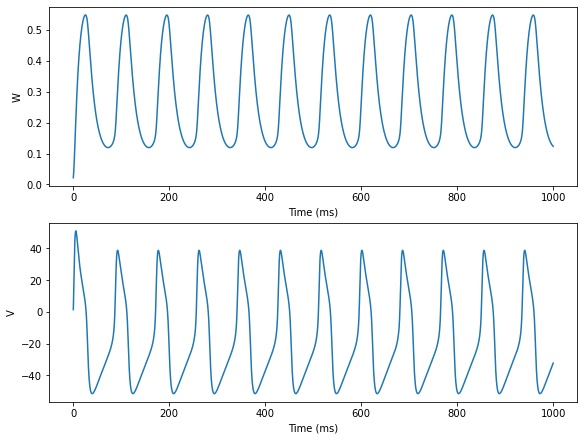

In [5]:
runner = bp.dyn.DSRunner(group, monitors=['V', 'W'], inputs=('input', 100.))
runner.run(1000)

fig, gs = bp.visualize.get_figure(2, 1, 3, 8)
fig.add_subplot(gs[0, 0])
bp.visualize.line_plot(runner.mon.ts, runner.mon.W, ylabel='W')
fig.add_subplot(gs[1, 0])
bp.visualize.line_plot(runner.mon.ts, runner.mon.V, ylabel='V', show=True)

Next we will also give users an intuitive understanding about building a network composed of different neurons and syanpses model. Users can simply initialize these models as below and pass into ``brainpy.dyn.Network``.

In [6]:
neu1 = bp.dyn.HH(1)
neu2 = bp.dyn.HH(1)
syn1 = bp.dyn.NMDA(neu1, neu2, bp.connect.All2All(), E=0.)
net = bp.dyn.Network(pre=neu1, syn=syn1, post=neu2)

By selecting proper runner, users can simulate the network efficiently and plot the simulation results.

  0%|          | 0/1500 [00:00<?, ?it/s]

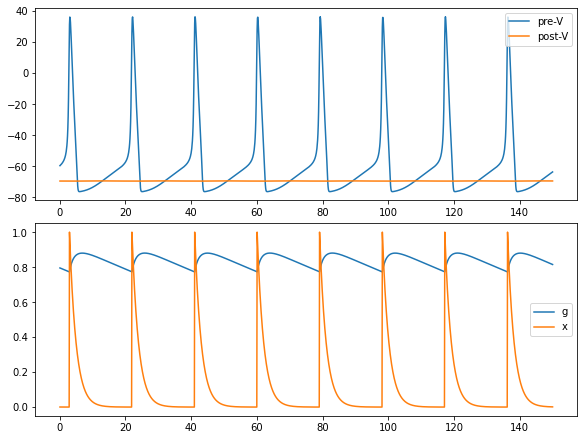

In [8]:
runner = bp.dyn.DSRunner(net, inputs=[('pre.input', 5.)], monitors=['pre.V', 'post.V', 'syn.g', 'syn.x'])
runner.run(150.)

import matplotlib.pyplot as plt

fig, gs = bp.visualize.get_figure(2, 1, 3, 8)
fig.add_subplot(gs[0, 0])
plt.plot(runner.mon.ts, runner.mon['pre.V'], label='pre-V')
plt.plot(runner.mon.ts, runner.mon['post.V'], label='post-V')
plt.legend()

fig.add_subplot(gs[1, 0])
plt.plot(runner.mon.ts, runner.mon['syn.g'], label='g')
plt.plot(runner.mon.ts, runner.mon['syn.x'], label='x')
plt.legend()
plt.show()